In [1]:
!pip install tensorflow==2.15.0
!pip install scikit-learn
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install matplotlib
!pip install wordcloud
!pip install nltk

In [2]:
#Load Libraries
#DL Packages

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

#ML Packages

from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import pickle
import nltk
import re
from nltk.stem import PorterStemmer

import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud

In [4]:
train_data = pd.read_csv("train.txt", header=None, sep=";", names=["Comment", "Emotion"], encoding="utf-8")
# get all words length in comment
train_data['length'] = [len(x) for x in train_data['Comment']]

In [5]:
train_data

,Comment,Emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20
...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,101
15996,i am now turning and i feel pathetic that i am...,sadness,102
15997,i feel strong and good overall,joy,30
15998,i feel like this was such a rude comment and i...,anger,59


In [6]:
train_data.shape

(16000, 3)

In [7]:
train_data.isnull().sum()

Comment    0
Emotion    0
length     0
dtype: int64

In [8]:
train_data.duplicated().sum()

1

In [12]:
train_data.drop_duplicates(inplace=True)

EDA

In [13]:
train_data['Emotion'].value_counts()

joy         5361
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: Emotion, dtype: int64

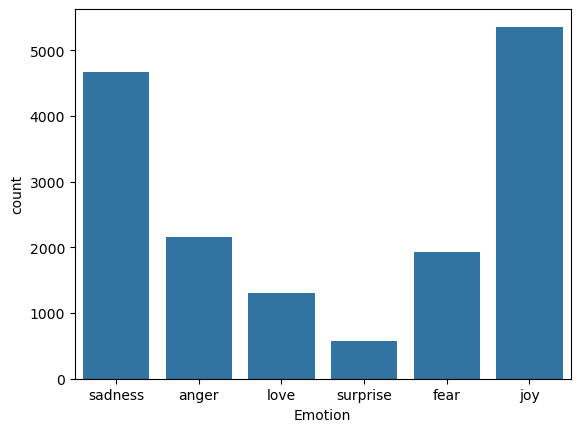

In [14]:
sns.countplot(x = train_data['Emotion'])
plt.show()

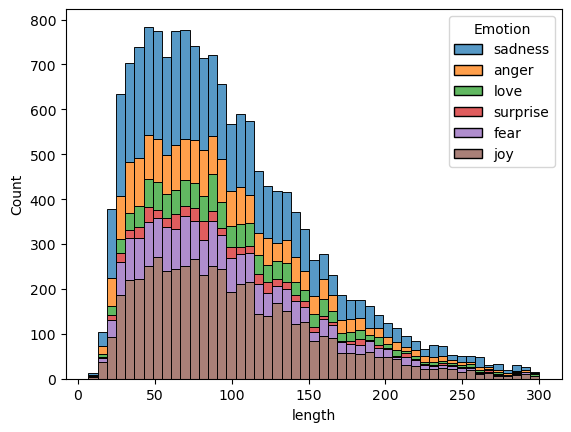

In [15]:
# data distribution
df2 = train_data.copy()
df2['length'] = [len(x) for x in df2['Comment']]

# Convert the 'length' column to a numpy array
length_values = df2['length'].values

# Use sns.histplot instead of sns.kdeplot for simplicity
sns.histplot(data=df2, x='length', hue='Emotion', multiple='stack')

plt.show()

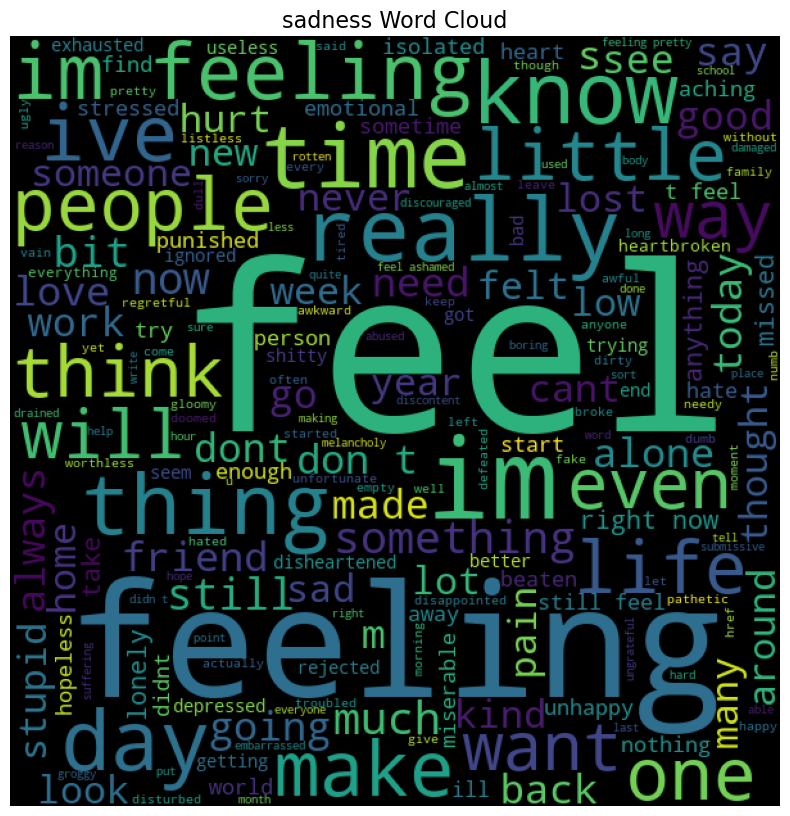

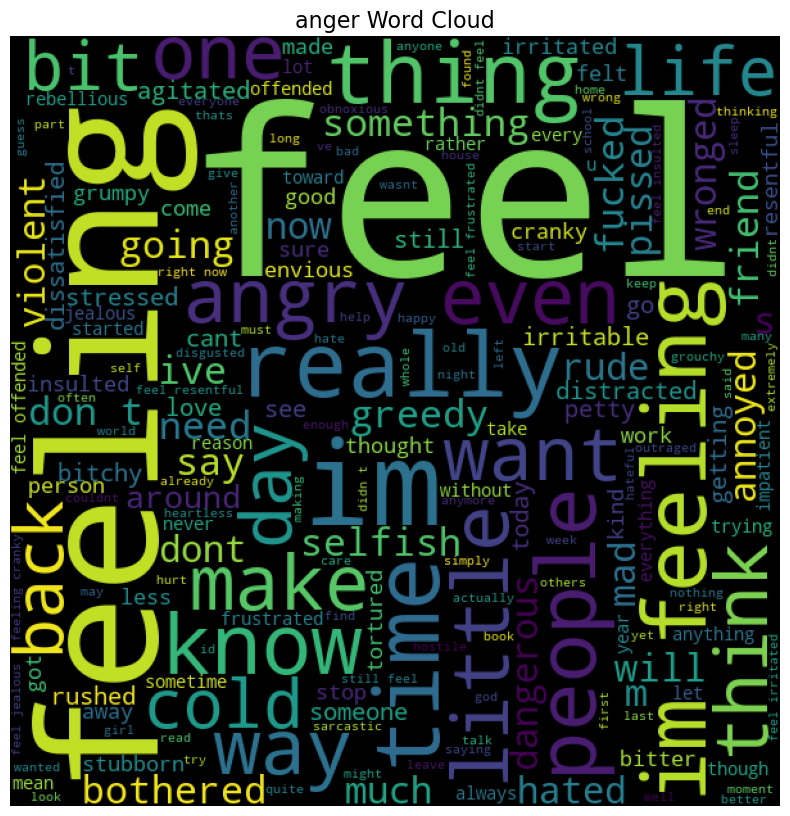

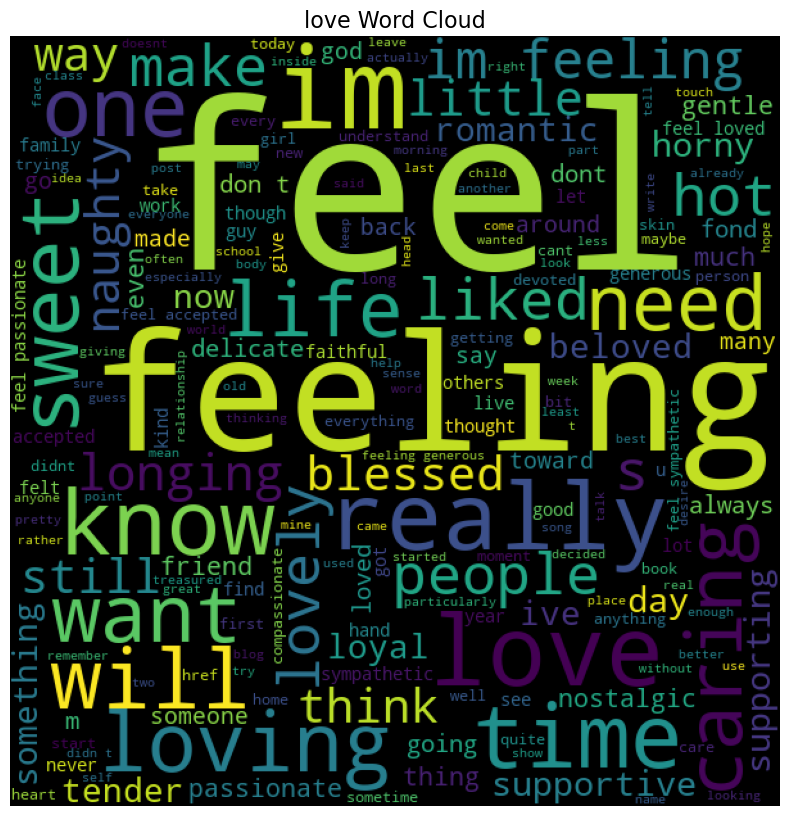

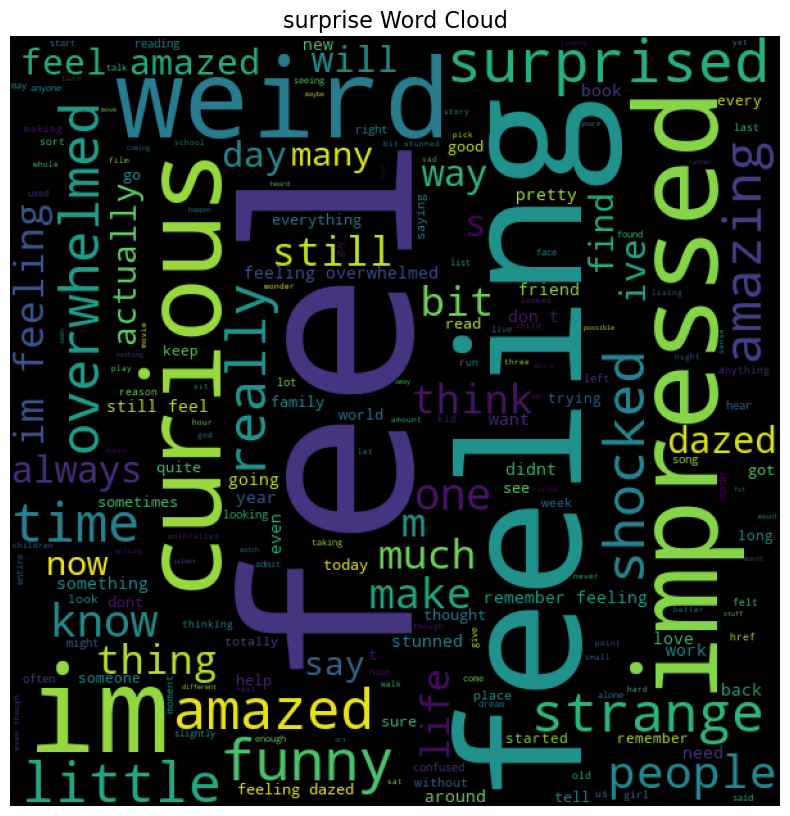

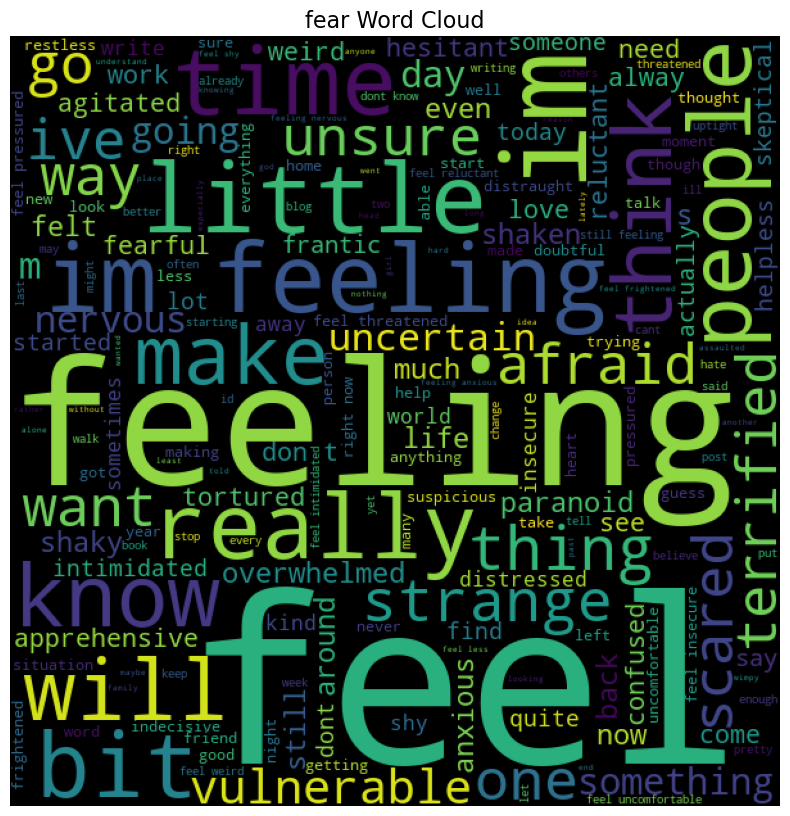

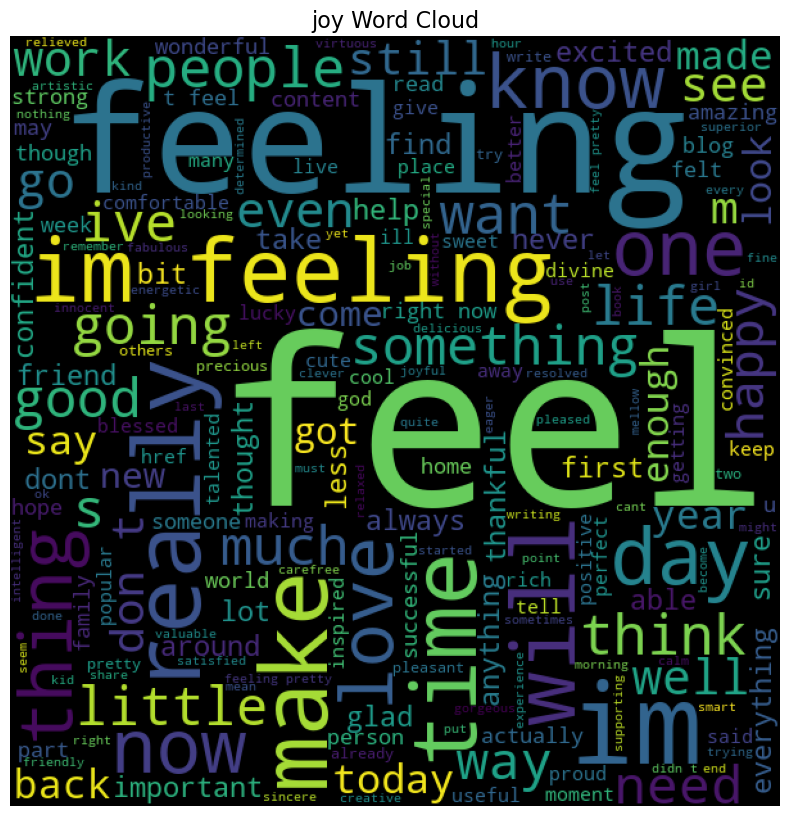

In [16]:
# Words cloud for each emotions
def words_cloud(wordcloud, df):
    plt.figure(figsize=(10, 10))
    plt.title(df+' Word Cloud', size = 16)
    plt.imshow(wordcloud)
    # No axis details
    plt.axis("off");
emotions_list = train_data['Emotion'].unique()
for emotion in emotions_list:
    text = ' '.join([sentence for sentence in train_data.loc[train_data['Emotion'] == emotion,'Comment']])
    wordcloud = WordCloud(width = 600, height = 600).generate(text)
    words_cloud(wordcloud, emotion)

In [18]:
from wordcloud import WordCloud

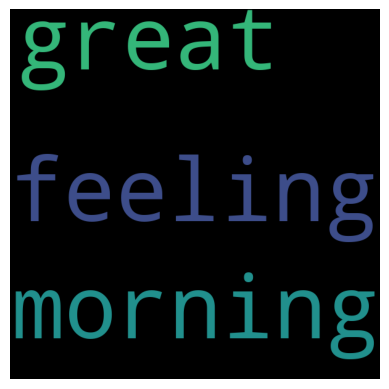

In [19]:
text = "I am feeling great since morning"
wc = WordCloud(width=600, height=600).generate(text)
plt.imshow(wc)
plt.axis('off')  # Remove axis
plt.show()

# Data Preprocessing

Encode Emotions


In [22]:
lb = LabelEncoder()
train_data['Emotion Encoded'] = lb.fit_transform(train_data['Emotion'])

In [23]:
train_data

,Comment,Emotion,length,Emotion Encoded
0,i didnt feel humiliated,sadness,23,4
1,i can go from feeling so hopeless to so damned...,sadness,108,4
2,im grabbing a minute to post i feel greedy wrong,anger,48,0
3,i am ever feeling nostalgic about the fireplac...,love,92,3
4,i am feeling grouchy,anger,20,0
...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,101,4
15996,i am now turning and i feel pathetic that i am...,sadness,102,4
15997,i feel strong and good overall,joy,30,2
15998,i feel like this was such a rude comment and i...,anger,59,0


In [24]:
# Before the Machine Learning section
# Define a list of all possible emotions
all_emotions = train_data['Emotion'].unique()

# Ensure all possible emotions are present in the label encoder
lb = LabelEncoder()
lb.fit(all_emotions)


LabelEncoder()

# Applying Machine Learning

In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [27]:
# copy df from train_data because we will use this for deep learing next
df = train_data.copy()

In [28]:
df

,Comment,Emotion,length,Emotion Encoded
0,i didnt feel humiliated,sadness,23,4
1,i can go from feeling so hopeless to so damned...,sadness,108,4
2,im grabbing a minute to post i feel greedy wrong,anger,48,0
3,i am ever feeling nostalgic about the fireplac...,love,92,3
4,i am feeling grouchy,anger,20,0
...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,101,4
15996,i am now turning and i feel pathetic that i am...,sadness,102,4
15997,i feel strong and good overall,joy,30,2
15998,i feel like this was such a rude comment and i...,anger,59,0


In [29]:
# Data cleaning and preprocessing
# Download NLTK stopwords
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
def clean_text(text):
    stemmer = PorterStemmer()
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    return " ".join(text)

df['cleaned_comment'] = df['Comment'].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\prani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
df

,Comment,Emotion,length,Emotion Encoded,cleaned_comment
0,i didnt feel humiliated,sadness,23,4,didnt feel humili
1,i can go from feeling so hopeless to so damned...,sadness,108,4,go feel hopeless damn hope around someon care ...
2,im grabbing a minute to post i feel greedy wrong,anger,48,0,im grab minut post feel greedi wrong
3,i am ever feeling nostalgic about the fireplac...,love,92,3,ever feel nostalg fireplac know still properti
4,i am feeling grouchy,anger,20,0,feel grouchi
...,...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,101,4,brief time beanbag said anna feel like beaten
15996,i am now turning and i feel pathetic that i am...,sadness,102,4,turn feel pathet still wait tabl sub teach degre
15997,i feel strong and good overall,joy,30,2,feel strong good overal
15998,i feel like this was such a rude comment and i...,anger,59,0,feel like rude comment im glad


In [33]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_comment'],df['Emotion'],test_size=0.2,random_state=42)

In [34]:
def predict_emotion(input_text):
    cleaned_text = clean_text(input_text)
    input_vectorized = tfidf_vectorizer.transform([cleaned_text])

    # Predict emotion
    predicted_label = lg.predict(input_vectorized)[0]

    # Check if the predicted label is present in the label encoder classes
    if predicted_label in lb.classes_:
        predicted_emotion = lb.inverse_transform([predicted_label])[0]
    else:
        # Manually add the predicted label to the label encoder classes
        lb_classes = list(lb.classes_)
        lb_classes.append(predicted_label)
        lb_classes.sort()
        lb.classes_ = lb_classes

        # Perform inverse transformation
        predicted_emotion = lb.inverse_transform([predicted_label])[0]

    label = np.max(lg.predict(input_vectorized))

    return predicted_emotion, label


In [35]:
# Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [36]:
# Multi-class classification using different algorithms
classifiers = {
    "Multinomial Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
}

for name, clf in classifiers.items():
    print(f"\n===== {name} =====")
    clf.fit(X_train_tfidf, y_train)
    y_pred_tfidf = clf.predict(X_test_tfidf)
    accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
    print(f"\nAccuracy using TF-IDF: {accuracy_tfidf}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred_tfidf))


===== Multinomial Naive Bayes =====

Accuracy using TF-IDF: 0.6590625
Classification Report:
              precision    recall  f1-score   support

       anger       0.95      0.32      0.48       439
        fear       0.88      0.23      0.37       375
         joy       0.58      0.98      0.73      1027
        love       1.00      0.03      0.05       303
     sadness       0.72      0.91      0.80       950
    surprise       1.00      0.02      0.04       106

    accuracy                           0.66      3200
   macro avg       0.85      0.42      0.41      3200
weighted avg       0.76      0.66      0.59      3200


===== Logistic Regression =====


C:\Users\prani\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Accuracy using TF-IDF: 0.8240625
Classification Report:
              precision    recall  f1-score   support

       anger       0.88      0.78      0.83       439
        fear       0.85      0.72      0.78       375
         joy       0.76      0.94      0.84      1027
        love       0.83      0.46      0.59       303
     sadness       0.88      0.92      0.90       950
    surprise       0.74      0.46      0.57       106

    accuracy                           0.82      3200
   macro avg       0.82      0.71      0.75      3200
weighted avg       0.83      0.82      0.82      3200


===== Random Forest =====

Accuracy using TF-IDF: 0.8496875
Classification Report:
              precision    recall  f1-score   support

       anger       0.82      0.86      0.84       439
        fear       0.83      0.86      0.84       375
         joy       0.84      0.90      0.87      1027
        love       0.81      0.59      0.69       303
     sadness       0.91      0.89      0.90  

In [42]:
# Selecting model
lg = LogisticRegression()
lg.fit(X_train_tfidf, y_train)
lg_y_pred = lg.predict(X_test_tfidf)

C:\Users\prani\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [46]:
#print(lb.classes_)

In [47]:
from sklearn.preprocessing import LabelEncoder

In [48]:
from sklearn.preprocessing import LabelEncoder

# Assuming lb is your label encoder
lb = LabelEncoder()
# Assuming labels is a list of all possible emotion labels, including 'sadness'
labels = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']
lb.fit(labels)

LabelEncoder()

In [49]:
def predict_emotion(input_text):
    cleaned_text = clean_text(input_text)
    input_vectorized = tfidf_vectorizer.transform([cleaned_text])

    # Predict emotion
    predicted_label = lg.predict(input_vectorized)[0]
    predicted_emotion = lb.inverse_transform([predicted_label])[0]

    label = np.argmax(lg.predict(input_vectorized))

    return predicted_emotion, label

# Example usage
sentences = [
            "i didnt feel humiliated",
            "i feel strong and good overall",
            "im grabbing a minute to post i feel greedy wrong",
            "He was speechles when he found out he was accepted to this new job",
            "This is outrageous, how can you talk like that?",
            "I feel like im all alone in this world",
            "He is really sweet and caring",
            "You made me very crazy",
            "i am ever feeling nostalgic about the fireplace i will know that it is still on the property",
            "i am feeling grouchy",
            "He hates you"
            ]
for sentence in sentences:
    print(sentence)
    pred_emotion, label = predict_emotion(sentence)
    print("Prediction :", pred_emotion)
    print("Label :", label)
    print("================================================================")

C:\Users\prani\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:729: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


i didnt feel humiliated


ValueError: y contains previously unseen labels: ['sadness']

In [52]:
# save files
import pickle
pickle.dump(lg,open("logistic_regresion.pkl",'wb'))
pickle.dump(lb,open("label_encoder.pkl",'wb'))
pickle.dump(tfidf_vectorizer,open("tfidf_vectorizer.pkl",'wb'))

In [53]:
import sklearn
print(sklearn.__version__) # We have to use this version in pycharm


1.3.2


In [56]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
lb = LabelEncoder()

# Fit the label encoder on the emotion labels
lb.fit(train_data["Emotion"])

# Transform emotion labels to numerical format
y_train_encoded = lb.transform(train_data["Emotion"])

# Convert numerical labels to categorical format
y_train = to_categorical(y_train_encoded)


# Applying Deep Learning LSTM Text Cleaning, Encoding and Padding


In [55]:
# Text cleaning function
def text_cleaning(df, column, vocab_size, max_len):
    stemmer = PorterStemmer()
    corpus = []

    for text in df[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        corpus.append(text)

    one_hot_word = [one_hot(input_text=word, n=vocab_size) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=max_len, padding='pre')
    return pad

# Text cleaning and encoding
x_train = text_cleaning(train_data, "Comment", vocab_size=11000, max_len=300)
y_train = to_categorical(train_data["Emotion"])

ValueError: invalid literal for int() with base 10: 'sadness'

# Model Building and Training

In [57]:
# Build and compile the model
model = Sequential()
model.add(Embedding(input_dim=11000, output_dim=150, input_length=300))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
callback = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
model.fit(x_train, y_train, epochs=10, batch_size=64, verbose=1, callbacks=[callback])

Epoch 1/10


250/250 [==============================] - 99s 382ms/step - loss: 1.5829 - accuracy: 0.3586
Epoch 2/10
250/250 [==============================] - 99s 398ms/step - loss: 0.8523 - accuracy: 0.7139
Epoch 3/10
250/250 [==============================] - 99s 396ms/step - loss: 0.3776 - accuracy: 0.8779
Epoch 4/10
250/250 [==============================] - 102s 407ms/step - loss: 0.2407 - accuracy: 0.9227
Epoch 5/10
250/250 [==============================] - 103s 411ms/step - loss: 0.1765 - accuracy: 0.9427
Epoch 6/10
250/250 [==============================] - 112s 448ms/step - loss: 0.1453 - accuracy: 0.9527
Epoch 7/10
250/250 [==============================] - 93s 369ms/step - loss: 0.1239 - accuracy: 0.9587
Epoch 8/10
250/250 [==============================] - 90s 361ms/step - loss: 0.1003 - accuracy: 0.9664
Epoch 9/10
250/250 [==============================] - 91s 365ms/step - loss: 0.0822 - accuracy: 0.9717
Epoch 10/10
250/250 [==============================] - 96s 384ms/ste

# Predictive System

In [58]:
# Text cleaning function
def sentence_cleaning(sentence):
    stemmer = PorterStemmer()
    corpus = []
    text = re.sub("[^a-zA-Z]", " ", sentence)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    text = " ".join(text)
    corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=11000) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=300, padding='pre')
    return pad

# load model and predict
sentences = [
            "i feel strong and good overall",
            "im grabbing a minute to post i feel greedy wrong",
            "He was speechles when he found out he was accepted to this new job",
            "This is outrageous, how can you talk like that?",
            "I feel like im all alone in this world",
            "He is really sweet and caring",
            "You made me very crazy",
            "i am ever feeling nostalgic about the fireplace i will know that it is still on the property",
            "i am feeling grouchy",
            "He hates you"
            ]
for sentence in sentences:
    print(sentence)
    sentence = sentence_cleaning(sentence)
    result = lb.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

i feel strong and good overall
1/1 [==============================] - 0s 39ms/step
joy : 0.9994713664054871


im grabbing a minute to post i feel greedy wrong
1/1 [==============================] - 0s 33ms/step
anger : 0.9975823163986206


He was speechles when he found out he was accepted to this new job
1/1 [==============================] - 0s 37ms/step
joy : 0.8788655400276184


This is outrageous, how can you talk like that?
1/1 [==============================] - 0s 36ms/step
anger : 0.983074963092804


I feel like im all alone in this world
1/1 [==============================] - 0s 38ms/step
sadness : 0.9985677003860474


He is really sweet and caring
1/1 [==============================] - 0s 38ms/step
love : 0.9541110992431641


You made me very crazy
1/1 [==============================] - 0s 34ms/step
anger : 0.5762704610824585


i am ever feeling nostalgic about the fireplace i will know that it is still on the property
1/1 [==============================] - 0s 40ms/step
love 

    # Save the model and files

In [59]:
model.save('model.h5')
# Save the LabelEncoder
with open('lb1.pkl', 'wb') as f:
    pickle.dump(lb, f)

# Save vocabulary size and max length
vocab_info = {'vocab_size': 11000, 'max_len': 300}
with open('vocab_info.pkl', 'wb') as f:
    pickle.dump(vocab_info, f)


C:\Users\prani\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
